In [7]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [8]:
'''GPU Availability'''
print('Graphic Card Availability: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device ID: ', device)
print("Device Name: ", torch.cuda.get_device_name(device))

X_train = torch.FloatTensor([0., 1., 2.])
print(X_train.is_cuda)

X_train = X_train.to(device)
print(X_train.is_cuda)

Graphic Card Availability:  True
Device ID:  cuda:0
Device Name:  NVIDIA GeForce RTX 3050 Ti Laptop GPU
False
True


In [9]:
'''Loading the image data via pytorch'''

data_dir = 'Driver Drowsiness Dataset (DDD)' #Enter the folder path, which contains the data

#Applying Transformation
transform = transforms.Compose([transforms.ToTensor()]) #Transformations, image to PyTorch tensors (Resize, crops, etc not needed as the data is already clean), Augmentations can be added afterwards

image_dataset = datasets.ImageFolder(data_dir, transform=transform)

train_test_split = 0.8

train_size = int(train_test_split * len(image_dataset))
sizes = (train_size, len(image_dataset) - train_size)
train_set, test_set = torch.utils.data.random_split(image_dataset, sizes)

train_data = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True) #returns batches of images and corresponding labels
test_data = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True) #returns batches of images and corresponding labels

class_names = ['drowsy', 'non-drowsy']

Train data size (batch of 32):  1045
Test data size (batch of 32):  262


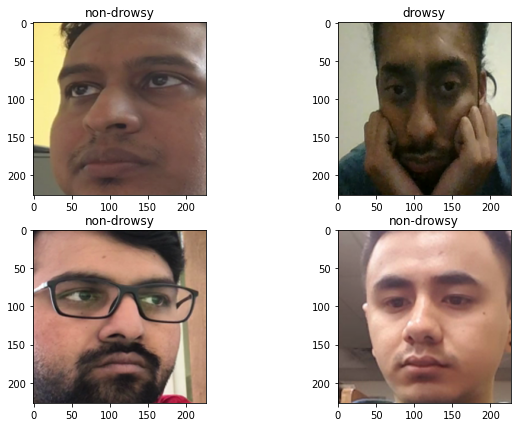

In [10]:
'''Plotting the Training Data'''
print('Train data size (batch of 32): ', len(train_data))
print('Test data size (batch of 32): ', len(test_data))

images, labels = next(iter(train_data))
fig = plt.figure(figsize=(10, 7))

for i in range(4):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    if labels[i]==0:
        state='drowsy'
    else:
        state='non-drowsy'  
    plt.title(state)

In [11]:
'''Defining the network'''

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [17]:
base_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)


for param in base_model.parameters():  #Lock the parameters of all layers of the base model (VGG11)
    param.requires_grad = False
    
features = list(base_model.classifier.children())[:-1] # Remove last layer of Base Model

number_features = base_model.classifier[6].in_features #Calculating the input features to the last layer
features.extend([torch.nn.Linear(number_features, len(class_names))]) #Output features of the last layer (2 class classification)

base_model.classifier = torch.nn.Sequential(*features) #Building the new classifier (to be trained via transfer learning)

if torch.cuda.is_available():
    base_model = base_model.cuda() #moving to GPU

print(base_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

Using cache found in C:\Users\stann/.cache\torch\hub\pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x46656 and 400x120)